# Doubles

Created by Kidror

```
# S12 and S13: works fine. ballpark factors here work out to -0.005 for neutral parks
dfc["threshold"] = 0.175 + 0.20*musc - 0.10*chase - 0.04*opw  + 0.03*fwd - 0.02*omi - 0.02*elong

 # S14: 2 outliers, fiddly ballpark coefs
dfc["threshold"] = 0.17 + 0.2*musc - 0.09*chase - 0.04*opw + 0.03*fwd - 0.02*omi - 0.02*elong

# S15: 3 outliers, fiddly ballpark coefs
dfc["threshold"] = 0.165 + 0.2*musc - 0.08*chase - 0.04*opw + 0.025*fwd - 0.01*omi - 0.025*elong
```

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-doubles.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

season = 14
df = df[df['season'] == season]
len(df)

5164

In [2]:
dfc = df.copy()
for exclude_mod in ["O_NO", "ON_FIRE", "OVERPERFORMING", "UNDERPERFORMING", "GROWTH", "HIGH_PRESSURE", "SINKING_SHIP", "TRAVELING", "CHUNKY", "SMOOTH", "SHELLED"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

batter_params = ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']
pitcher_params = ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']
for attr in batter_params:
    dfc[attr] = dfc[attr] * df['batter_multiplier']
for attr in pitcher_params:
    dfc[attr] = dfc[attr] * df['pitcher_multiplier']

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0
dfc.loc[dfc["fielder_mods"].astype(str).str.contains("SCATTERED"),"fielder_vibes"] = 0

dfc = dfc[dfc["batter_multiplier"] == 1]
dfc = dfc[dfc["pitcher_multiplier"] == 1]

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

dfc["musc_vibes"] = dfc["batter_musclitude"] * (1 + 0.2*dfc["batter_vibes"])
dfc["ind_vibes"] = dfc["batter_indulgence"] * (1 + 0.2*dfc["batter_vibes"])
dfc["gf_vibes"] = dfc["batter_ground_friction"] * (1 + 0.2*dfc["batter_vibes"])
dfc["opw_vibes"] = dfc["pitcher_overpowerment"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["unthwack_vibes"] = dfc["pitcher_unthwackability"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["ruth_vibes"] = dfc["pitcher_ruthlessness"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["shakes_vibes"] = dfc["pitcher_shakespearianism"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["supp_vibes"] = dfc["pitcher_suppression"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["chase_vibes"] = dfc["fielder_chasiness"] * (1 + 0.2*dfc["fielder_vibes"])
dfc["cold_vibes"] = dfc["pitcher_coldness"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["omni_vibes"] = dfc["pitcher_omniscience"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["invpath"] = 1 - dfc["batter_patheticism"] * (1 + 0.2*dfc["batter_vibes"])
dfc["park_park"] = dfc["ballpark_forwardness"] + dfc["ballpark_viscosity"] - dfc["ballpark_ominousness"]

X = dfc[["roll",
         "musc_vibes",
         "opw_vibes",
         "chase_vibes",
           "ballpark_forwardness",
         # "ballpark_viscosity",
           "ballpark_ominousness",
         # "ballpark_grandiosity",
         # "ballpark_obtuseness",
         # "ballpark_inconvenience",
           "ballpark_elongation",
        ]]
y = dfc['passed']

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, C=100000, max_iter=10000, tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
confusion_matrix(y,predictionsvm)

array([[2110,    0],
       [   0,  615]])

In [4]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

2110
615


In [5]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[(1.0, 'roll'),
 (-0.19828087620380996, 'musc_vibes'),
 (0.08047544274449925, 'chase_vibes'),
 (0.03916779684226092, 'opw_vibes'),
 (-0.027654862698667966, 'ballpark_forwardness'),
 (0.02412408772434682, 'ballpark_elongation'),
 (0.010526815321451617, 'ballpark_ominousness')]

In [6]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([-0.16514532])

In [7]:
opw = dfc["pitcher_overpowerment"] * (1 + 0.2*dfc["pitcher_vibes"])
grand = dfc["ballpark_grandiosity"]
vis = dfc["ballpark_viscosity"]
fwd = dfc["ballpark_forwardness"]
omi = dfc["ballpark_ominousness"]
elong = dfc["ballpark_elongation"]
musc = dfc["batter_musclitude"] * (1 + 0.2*dfc["batter_vibes"])
sup = dfc["pitcher_suppression"] * (1 + 0.2*dfc["pitcher_vibes"])
omni = dfc["pitcher_omniscience"] * (1 + 0.2*dfc["pitcher_vibes"])
obtuse = dfc["ballpark_obtuseness"]
incon = dfc["ballpark_inconvenience"]
chase = dfc["fielder_chasiness"] * (1 + 0.2*dfc["fielder_vibes"])
cold = dfc["pitcher_coldness"] * (1 + 0.2*dfc["pitcher_vibes"])

# Musc, OPW, FWD, Grand, OMI, Probably Fielder Chasiness
# S12 & 13- 0.17 + 0.2*musc - 0.1*chase - 0.04*opw
# S14 0.1575 + 0.2*musc - 0.09*chase - 0.04*opw - 0.0125*vis + 0.0275*fwd + 0.006*omi

# dfc["threshold"] = 0.1565 + 0.2*musc - 0.1*chase - 0.04*opw - 0.0125*vis + 0.0275*fwd + 0.0065*omi

dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

# S12 and S13: works fine. ballpark factors here work out to -0.005 for neutral parks
dfc["threshold"] = 0.175 + 0.20*musc - 0.10*chase - 0.04*opw  + 0.03*fwd - 0.02*omi - 0.02*elong

 # S14: 2 outliers, fiddly ballpark coefs
dfc["threshold"] = 0.17 + 0.2*musc - 0.09*chase - 0.04*opw + 0.03*fwd - 0.02*omi - 0.02*elong

# S15: 3 outliers, fiddly ballpark coefs
dfc["threshold"] = 0.165 + 0.2*musc - 0.08*chase - 0.04*opw + 0.025*fwd - 0.01*omi - 0.025*elong


[0.16514532]
(0.19828087620380996, 'musc_vibes')
(-0.03916779684226092, 'opw_vibes')
(-0.08047544274449925, 'chase_vibes')
(0.027654862698667966, 'ballpark_forwardness')
(-0.010526815321451617, 'ballpark_ominousness')
(-0.02412408772434682, 'ballpark_elongation')


3


,offset,weather,event_type,batter_musclitude,pitcher_overpowerment,roll,threshold,fielder_name,fielder_chasiness,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count
10350,0.000144,Weather.SALMON,Hit2,0.709089,0.830381,0.221736,0.221592,Thomas Dracaena,0.711973,Marquez Clark,Fynn Doyle,REPEATING,ALTERNATE,MIDDLING,BIRD_SEED,80,5a42ce29-a2c4-4cf0-aa98-15247deafea7,48
11169,0.000208,Weather.FLOODING,Hit2,0.583585,0.435854,0.189331,0.189123,D---in -o-c-y-a,0.644453,Paula Turnip,Kathy Mathews,COFFEE_RALLY,ALTERNATE,FIREPROOF;SEALANT;AMBUSH,NaN,86,dc38fee5-62fd-42f2-a6c1-6aa73efd0ece,184
9584,0.000784,Weather.SALMON,Hit2,0.608891,0.951024,0.237799,0.237015,Erin Jesaulenko,0.284152,Randy Castillo,Geraldine Frost,NaN,NaN,FIREPROOF;SEALANT;AMBUSH,UNDERSEA,47,e4e2cf9b-35a8-4f1c-aa0b-05ad8881a1ba,310


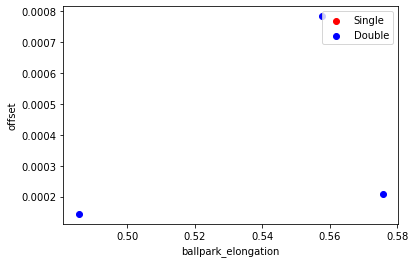

In [8]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "ballpark_elongation"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Single")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Double")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
print(len(table))
table[["offset", "weather", "event_type", "batter_musclitude", "pitcher_overpowerment",
       "roll", "threshold",
       "fielder_name", "fielder_chasiness",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count"]].sort_values('offset')


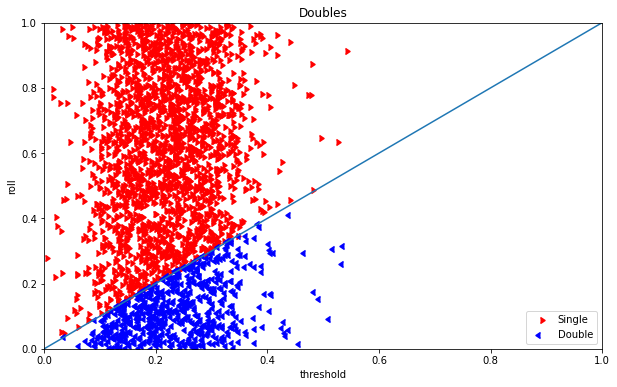

In [9]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="Single", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Double", marker=CARETLEFTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Doubles")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.legend()

In [10]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.4107987574231906
0.049438488915765
